#### Artificial Neural Network (ANN): Classification

-  In this model, the intention is a person is sports person or not.
-  _This model is simple and predicted well._

- __Import Libraries__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Activation, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

- __Downloading packages__

In [2]:
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/preethamvignesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

-  __Cleaning the text, plotting, and prediction functions__

In [3]:
#Cleans Text
def normalizer(tweet):
    no_urls = re.sub(r"http\S+", " " ,tweet)
    only_letters = re.sub("[^a-zA-Z]", " ",no_urls)
    tokens = nltk.word_tokenize(only_letters)[2 :]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    #lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return filtered_result

#Generate Plots for Model
def plot_graphs(history, metric):
  plt.figure( figsize=(16,12))
  plt.rcParams.update({'font.size': 22})
  plt.plot(history.history[metric])
  #plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

#make a prediction on input text
def predict_on_text(text):
  
  test_text = np.array([text])
  test_df =  pd.DataFrame(test_text, columns = ['text'])

  test_df['normalized_tweet'] = test_df.text.apply(normalizer)
  X = test_df["normalized_tweet"].astype(str)

  df = token.texts_to_sequences(X)

  df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)

  prediction = np.round(model.predict(df)[0][0])

  if prediction:

    return "This is about Sports."

  else:

    return "This is not about Sports."

# compute accuracy
def accuracy(y, y_hat):

  acc = np.mean(y == y_hat)

  print('The accuracy is: ' + str(acc))

#generates confusion matrix
def confusionMatrix(ys,preds):
    
    N = len(ys)
    #Generate empty matrix
    confuse = np.zeros((2,2),dtype=int)
    
    #loop through both arrays
    for i in range(N):
    
      #increase count in entry of each label
      confuse[ys[i],int(preds[i])] = confuse[ys[i],int(preds[i])] + 1
    
    #return as dataframe
    return pd.DataFrame(confuse)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


- __Read the datasets__

In [5]:
#uploaded = files.upload()

df = pd.read_csv("~/Desktop/Work/ML_EIT/Data/sports_data.csv")

#map data labels to 0 or 1 
df.label = df["label"].replace({"not_sports":0,"sports":1})

#add cleaned data to the DataFrame
df['normalized_tweet'] = df.title.apply(normalizer)

#seperate X and y out as DataFrames
X = df["normalized_tweet"].astype(str)
y = df["label"]

In [6]:
df.head()

,Unnamed: 0,title,subreddit,label,normalized_tweet
0,0,Fake News Report: Orient Daily Newspaper Tende...,religion,0,"[report, orient, daily, newspaper, tenders, ap..."
1,1,How to get signed/tryout for any ACB team?,Basketball,1,"[get, signed, tryout, acb, team]"
2,2,So calming 🍃,Forest,0,[]
3,3,How violent is Rezero compared to Attack on ti...,anime,0,"[rezero, compared, attack, titan, vinland, saga]"
4,4,Forest near a little vilage in Mk,Forest,0,"[little, vilage, mk]"


In [7]:
max_features = 50000 #we set maximum number of words to 5000
max_length = 100 #we set maximum sequence length to 400
embedding_dim = 50 

token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features) 
token.fit_on_texts(X)

vocab_size = len(token.word_index) + 1 

#conver X to a TensorFlow Type and add padding
df = token.texts_to_sequences(X)
df = tf.keras.preprocessing.sequence.pad_sequences(df, maxlen=max_length)


- __Split the datasets__

In [8]:
df = df.astype('int')
X_train, X_test, y_train, y_test = train_test_split(df, y,test_size=0.15,random_state=101)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=1)

In [9]:
# determine the number of input features
n_features = X_train.shape[1]
n_features

100

- __Model architecture__

In [10]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=max_length))
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid',kernel_initializer='uniform'))

model.compile(optimizer="adam",
             loss='binary_crossentropy',metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           662800    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 663,633
Trainable params: 663,633
Non-trainable params: 0
_________________________________________________________________


In [11]:
history=model.fit(np.array(X_train), np.array(y_train), batch_size=50,epochs=10) 

Epoch 1/10
185/185 [==============================] - 2s 8ms/step - loss: 0.6759 - accuracy: 0.6756
Epoch 2/10
185/185 [==============================] - 1s 8ms/step - loss: 0.3371 - accuracy: 0.8919
Epoch 3/10
185/185 [==============================] - 1s 8ms/step - loss: 0.1405 - accuracy: 0.9537
Epoch 4/10
185/185 [==============================] - 1s 8ms/step - loss: 0.0867 - accuracy: 0.9690
Epoch 5/10
185/185 [==============================] - 1s 8ms/step - loss: 0.0646 - accuracy: 0.9751
Epoch 6/10
185/185 [==============================] - 1s 8ms/step - loss: 0.0601 - accuracy: 0.9743
Epoch 7/10
185/185 [==============================] - 2s 9ms/step - loss: 0.0558 - accuracy: 0.9735
Epoch 8/10
185/185 [==============================] - 2s 8ms/step - loss: 0.0545 - accuracy: 0.9730
Epoch 9/10
185/185 [==============================] - 1s 8ms/step - loss: 0.0514 - accuracy: 0.9739
Epoch 10/10
185/185 [==============================] - 1s 8ms/step - loss: 0.0505 - accuracy: 0.9733

In [12]:
model.evaluate(X_test,y_test)

57/57 [==============================] - 0s 1ms/step - loss: 0.2874 - accuracy: 0.9024


[0.28743335604667664, 0.9024255871772766]

Epoch 1/20
178/178 [==============================] - 2s 12ms/step - loss: 0.0491 - accuracy: 0.9756 - val_loss: 0.2873 - val_accuracy: 0.9013
Epoch 2/20
178/178 [==============================] - 1s 8ms/step - loss: 0.0485 - accuracy: 0.9749 - val_loss: 0.2929 - val_accuracy: 0.8980
Epoch 3/20
178/178 [==============================] - 1s 8ms/step - loss: 0.0489 - accuracy: 0.9746 - val_loss: 0.2964 - val_accuracy: 0.8980
Epoch 4/20
178/178 [==============================] - 1s 8ms/step - loss: 0.0476 - accuracy: 0.9760 - val_loss: 0.2979 - val_accuracy: 0.8991
Epoch 5/20
178/178 [==============================] - 1s 8ms/step - loss: 0.0476 - accuracy: 0.9759 - val_loss: 0.3010 - val_accuracy: 0.8980
Epoch 6/20
178/178 [==============================] - 1s 8ms/step - loss: 0.0473 - accuracy: 0.9744 - val_loss: 0.3057 - val_accuracy: 0.8980
Epoch 7/20
178/178 [==============================] - 1s 8ms/step - loss: 0.0471 - accuracy: 0.9765 - val_loss: 0.3071 - val_accuracy: 0.8975
Epoch

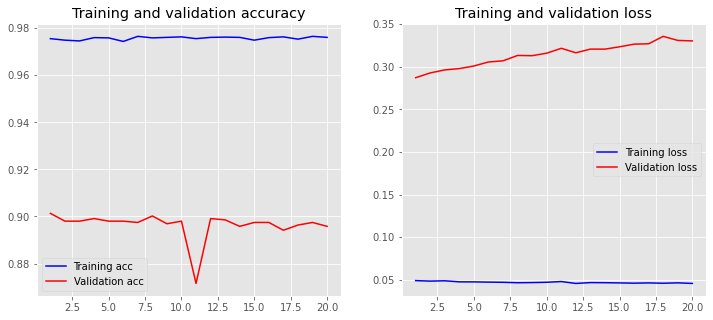

In [13]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=52)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

- Predict the test data and evaluate the confusion matrix and accuracy

In [14]:
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

con_res = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Confusion matrix:
[[844  63]
 [126 781]]
Accuracy: 89.58%


**Confusion matrix**

- More information and different ways of confusion matrix: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

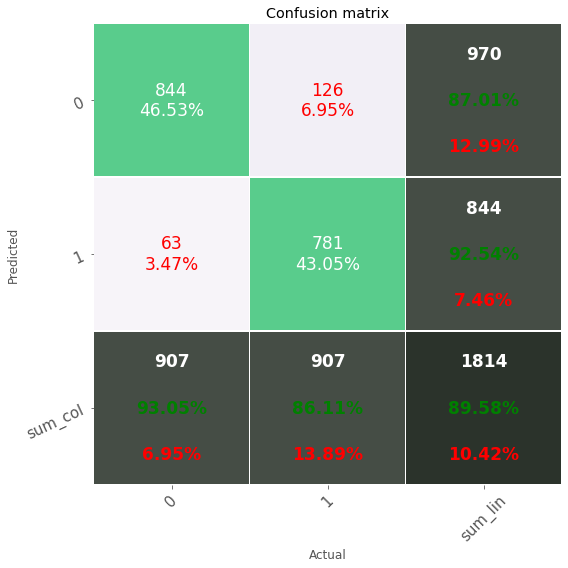

In [15]:
%run -i 'confusion_matrix_different_ways.py'
df_confmatrx = pd.DataFrame(con_res, range(2),range(2))
df_confmatrx
cmap = 'PuRd'
confusion_matrix_dfrntway(df_confmatrx, cmap=cmap,fz=17)